<img src='./figures/logo-ecole-polytechnique-ve.jpg' style='position:absolute; top:0; right:0;' width='100px' height='' alt='' />

<center>**Bachelor of Science of **</center>
<center>**Ecole Polytechnique** </center>

# Project: Malaria 

### Student: Megi Dervishi

In [181]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("./style/customProject.css").read()
    return HTML(styles)
css_styling()

## Table of contents

- [Introduction](#intro)
- [Studying the dataset](#data)
- [Generating new data](#unsupervised learning)
- [CNN](#cnn)
- [Transfer learning](#tr)
- [Unsupervised learning](#v)

- Bibliography

In [183]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

from imutils import paths
import cv2
import random
import time
#import skimage
#from skimage import transform
#from skimage import util
import gc

import sklearn
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import vgg16

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
import seaborn as sns

## Introduction

Malaria remains one of the most life-threatening diseases caused by parasites which are transmitted by the bite of a mosquito. Diagnosing such disease is time consuming. The topic of our project is hence –

***How can we best classify infected and uninfected cells of malaria using machine learning?*** 

The approach we have undertaken is by first studying the dataset, data augmentation, building our own CNN model as well as trying already built CNNs by comparing their accuracies.

## Studying the Dataset

The database is composed by 27,558 RGB images of 64 by 64 pixels. The images are balanced between two classes Parasitized and Uninfected each of them containing 13,779 images. The number of labels is hence 27,558 and the number of features is 12,288. The dataset is taken from a Kaggle Competition under the following [link](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria).

In [184]:
def load_malaria_data():
    """Loads the Malaria dataset using Keras and preprocess for training."""
    
    print("Loading images...")
    im_dataframe = pd.DataFrame()
    data = []
    labels = [] # 0= uninfected 1= infencted
    str_labels = [] # 'Parasitized, Uninefected'
    #randomly choosing images from the folder
    imagePaths = sorted(list(paths.list_images("./cell_images/All")))
    random.seed(time.time())
    random.shuffle(imagePaths)
    for imagePath in imagePaths:
        #resizing and flattening the images into 64X64x3 pixels
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (64, 64))
        data.append(image)
        #spliting the images
        str_label = imagePath.split(os.path.sep)[-2]
        str_labels.append(str_label)
        if str_label == 'Uninfected':
            labels.append(0)
        else:
            labels.append(1)
    data = np.array(data)
    labels = np.array(labels)
    str_labels = np.array(str_labels)
    im_dataframe['Labels'] = [list(_) for _ in keras.utils.to_categorical(labels, 2)]
    print("Loading dataset done.")
    return data, labels, str_labels

data, labels, str_labels = load_malaria_data()
#print(set(str_labels))

Loading images...
Loading dataset done.


In [185]:
#data.shape
print("Total Cells {} images".format(data.shape[0]))
print("Parasitized Cells {} images". format(sum(labels)))
print("Uninfected Cells {} images".format(data.shape[0] - sum(labels)))
print("Shape of the images is {}".format(data[0].shape))
print("Number of labels is ", labels.shape)
print("Number of features is", data[0].flatten().shape)

Total Cells 27558 images
Parasitized Cells 13779 images
Uninfected Cells 13779 images
Shape of the images is (64, 64, 3)
Number of labels is  (27558,)
Number of features is (12288,)


<div markdown=1 class="Rmk"> 


The following images is a sample from the randomized data representing the two classes: Infected (Parasitized) and Healthy (Uninfected) cells of malaria. 

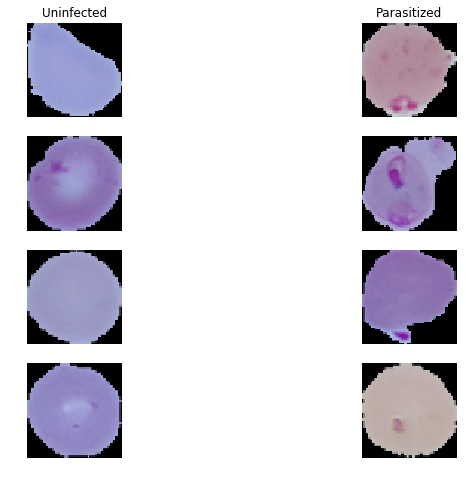

In [186]:
def showing_n_images_in_categories(n, images, categories, file_name=None, onof = 'off'):
    """Plots n random images in each category from the image data."""
    f, axes = plt.subplots(n, 2, figsize=(11,8))
    for i in range(2):
        count = 0
        j = 0
        while count < n and j < 50000:
            if categories[j] == i:
                axes[count,i].imshow(images[j])
                axes[count,i].axis(onof)
                if count == 0:
                    if i == 0:
                        axes[count,i].set_title('Uninfected')
                    else:
                        axes[count,i].set_title('Parasitized')
                count += 1
            j += 1
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

showing_n_images_in_categories(4, data, labels)

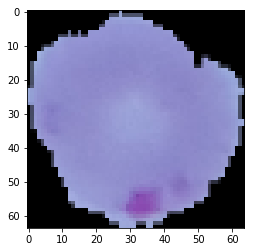

(20668,)
Parasitized,  1


In [187]:
#Splitting of training and testing data
(train_features, test_features, train_labels, test_labels) = train_test_split(data, labels, test_size=0.25, shuffle =True)

#Plotting of an image
train_features = train_features.astype('float32') / 255
test_feautres  = test_features.astype('float32') / 255
plt.imshow(train_features[0,:,:])
plt.show()
print(train_labels.shape )
if train_labels[0] : print("Parasitized, ",train_labels[0])
else: print("Uninfected, ", train_labels[0] )

### t-SNE vs PCA

The dataset is multidimensional therefore we used dimensionality reduction such as PCA to analyze it better. We have plotted 5000 points of infected (1) and uninfected (0) cells. As we can see we can’t really distinguish the data very well in order to analyze it better. Hence, we used another technique which in collaboration with PCA can give us an improved classification. The mathematics and algorithmic details of t-SNE will be explained during the presentation. Using t-SNE we obtain some sort of division however it is clear that it is impossible to clearly distinguish it. Some data are just not meant to be studied when reduced.

In [188]:
#Changing the dataset into a dataframe
n = 64*64*3
features = ['pixel'+str(i) for i in range(n)]
data2 = data.reshape(27558, n)
df = pd.DataFrame(data2, columns=features)
df['y'] = labels
np.random.seed(42)
perm = np.random.permutation(df.shape[0]) #randomize the dataset

N = 5000 #number of points
df_subset = df.loc[perm[:N],:].copy() #choosing a subset of the dataset
data_subset = df_subset[features].values

Text(0.5,1,'Number of components vs Cummulative explained variance')

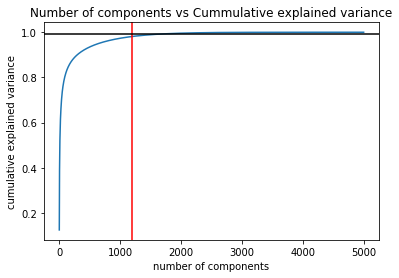

In [189]:
#how many components should pca be 
pca = PCA().fit(data_subset)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(1200, c='red')
plt.axhline(0.991, c='black')
plt.title("Number of components vs Cummulative explained variance")

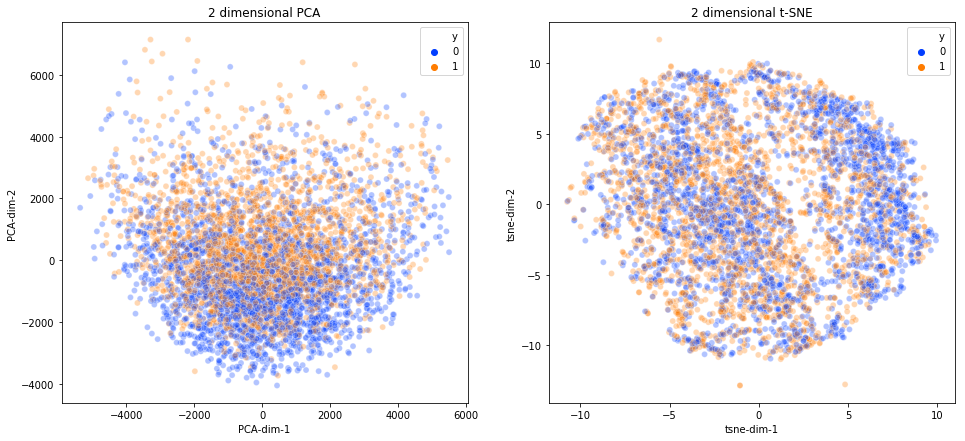

In [190]:
#PCA using dimension reduction of 1200 components
pca2 = PCA(n_components=1200)
pca_result = pca2.fit_transform(data_subset)
df_subset['PCA-dim-1'] = pca_result[:,0]
df_subset['PCA-dim-2'] = pca_result[:,1]

#t-SNE dimensionality reduction using pca results for more efficient results
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
df_subset['tsne-dim-1'] = tsne_results[:,0]
df_subset['tsne-dim-2'] = tsne_results[:,1]

#plot of the two methods
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title("2 dimensional PCA")
sns.scatterplot(x="PCA-dim-1", y="PCA-dim-2",hue="y",palette="bright",
                data=df_subset, legend="full",alpha=0.3, ax = ax1)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title("2 dimensional t-SNE")
sns.scatterplot(x="tsne-dim-1", y="tsne-dim-2",hue="y", palette="bright",
                data=df_subset, legend="full", alpha=0.3, ax=ax2)

plt.show()

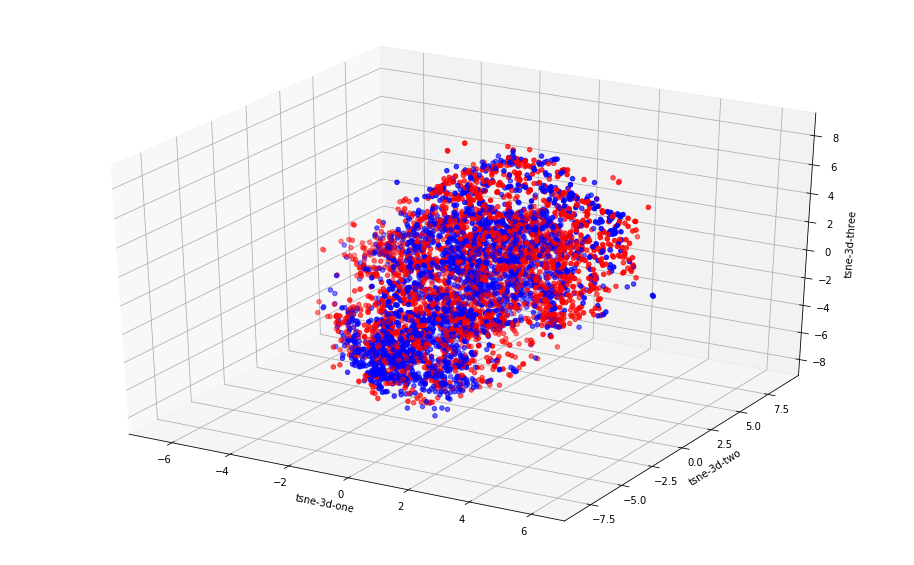

In [201]:
#3D plot
newpca = PCA(n_components=50)
pca_result_2 = newpca.fit_transform(data_subset)
_3D_tsne = TSNE(n_components=3, verbose=0, perplexity=50, n_iter=300)
tsne_results = _3D_tsne.fit_transform(pca_result_2)
df_subset['tsne-3d-one'] = tsne_results[:,0]
df_subset['tsne-3d-two'] = tsne_results[:,1]
df_subset['tsne-3d-three'] = tsne_results[:,2]

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_subset['tsne-3d-one'], 
    ys=df_subset['tsne-3d-two'], 
    zs=df_subset['tsne-3d-three'], 
    c=df_subset["y"], 
    cmap='bwr'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()

## Data Augmentation

The goal of this section is to generate extra-images to train on, because when we first tried to train the CNN from ImageNet on this dataset it always overfitted the training data. We first show a manual way of implementing the data augmentation, but since it is not optimized and quite memory expensive in the following we will use keras's pre-done function ImageDataGenerator.

In [ ]:
def rand_rot(im):
    deg = random.uniform(180, -180)
    return skimage.transform.rotate(im, deg)

def flipH(im):
    return im[:,::-1]

def flipV(im):
    return im[::-1, :]

def rand_noise(im):
    return skimage.util.random_noise(im)

f, axes = plt.subplots(5, 2, figsize=(11,8))
for i in range(2):
    j = 0
    while j < 50000:
        if labels[j] == i:
            axes[0,i].imshow(data[j])
            axes[0,i].axis('off')
            axes[0,i].set_title(labels[j])
            axes[1,i].imshow(rand_rot(data[j]))
            axes[2,i].imshow(flipH(data[j]))
            axes[3,i].imshow(flipV(data[j]))
            axes[4,i].imshow(rand_noise(data[j]))
            break
        j += 1

plt.show()

In [192]:
#modify images
image_gen = ImageDataGenerator(rescale = 1./255, rotation_range=15,
                               horizontal_flip=True, vertical_flip=True)

train_generator = image_gen.flow_from_directory(directory=r'./cell_images/Training',
                                                class_mode="categorical",
                                                target_size=(64, 64), 
                                                batch_size=32,
                                                color_mode="rgb",
                                                shuffle = True)
#does not modify the images for test data
test_datagen = ImageDataGenerator(rescale=1./255)
#generates images for test data
validation_generator = test_datagen.flow_from_directory(directory='./cell_images/Testing',
                                                       class_mode ="categorical",
                                                       target_size=(64, 64),
                                                       color_mode="rgb",
                                                       batch_size=32,
                                                       shuffle = True)

Found 20668 images belonging to 2 classes.
Found 6890 images belonging to 2 classes.


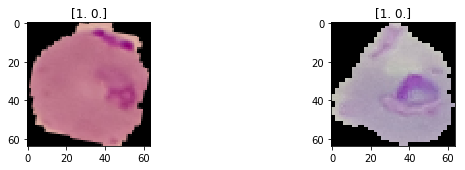

In [193]:
#printing of one of the modified images
x,y = train_generator[0]
image1 = x[0]
#printing not the modified image
x2,y2 = validation_generator.next()
image2 = x2[0]

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(2,2,1)
ax1.set_title(str(y[0]))
ax1.imshow(image1)
ax2 = fig.add_subplot(2,2,2)
ax2.set_title(str(y2[0]))
ax2.imshow(image2)

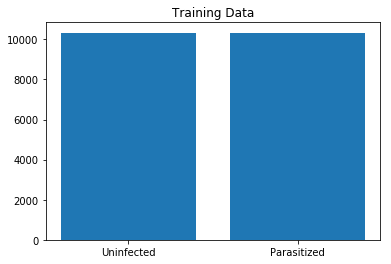

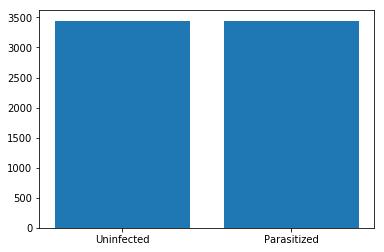

In [194]:
#Because of the splititng of the data we check if they are balanced or not
nb_uninfected = sum(train_generator.classes)
nb_infected = len(train_generator.classes)-nb_uninfected
plt.title("Training Data")
plt.bar([0, 1], [nb_uninfected, nb_infected])
plt.xticks([0, 1], ['Uninfected', 'Parasitized'])
plt.show()

#same here 
nb_uninfected = sum(validation_generator.classes)
nb_infected = len(validation_generator.classes)-nb_uninfected
plt.bar([0, 1], [nb_uninfected, nb_infected])
plt.xticks([0, 1], ['Uninfected', 'Parasitized'])
plt.show()

## CNN Model

In [195]:
### our own CNN
def cnn_model(inputShape, num_classes):
    model = keras.models.Sequential()
    model.add(Conv2D(filters=16,kernel_size=(2,2),padding="same",activation="relu",input_shape=inputShape))
    model.add(MaxPooling2D(pool_size=3))
    model.add(Conv2D(filters=32,kernel_size=(2,2),padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=3))
    model.add(Conv2D(filters=64,kernel_size=(2,2),padding="same",activation="relu"))
    model.add(MaxPooling2D(pool_size=3))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(500,activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes,activation="softmax"))
    model.compile(optimizer="adam",loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [196]:
(train_features, test_features, train_labels, test_labels) = train_test_split(data, labels, test_size=0.25, shuffle =True)

train_features = train_features.astype('float32') / 255
test_feautres  = test_features.astype('float32') / 255
train_labels = keras.utils.to_categorical(train_labels, 2)
test_labels  = keras.utils.to_categorical(test_labels, 2)
print(len(train_labels))
print(len(test_labels))


20668
6890


In [197]:
# Train model and save weights
model = cnn_model(train_features.shape[1:], 2)
Wsave = model.get_weights()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 21, 32)        2080      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)          8256      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 2, 64)         

In [202]:
#TD code
def train_model(model, x, y, x_test, y_test, batch_size=128, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """
    stop_early = keras.callbacks.EarlyStopping(
        monitor='val_accuracy', min_delta=0, patience=2, mode='auto')
    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, 
        validation_data=(x_test, y_test), shuffle=True, callbacks=[stop_early])
    if file_name:
        model.save(file_name) 
    return ret

#updated code for augmented_data
def train_model_augmented_data(model, generator, test_gen, batch_size, N_Images_train, N_Images_test, epochs, file_name=None):
    """
    Trains the model with the data fed from the generator.
    """
    stop_early = keras.callbacks.EarlyStopping(
        monitor='val_accuracy', min_delta=0, patience = 2, mode = 'auto')
    ret = model.fit_generator(generator, epochs=epochs, workers = 16, 
                              steps_per_epoch = N_Images_train // batch_size, shuffle = True,
                             callbacks=[stop_early], validation_data=test_gen,
                             validation_steps=N_Images_test // batch_size)
    return ret

In [199]:
#training for the non-augmented data
ret = train_model(model, train_features, train_labels, test_features, test_labels)

Train on 20668 samples, validate on 6890 samples
Epoch 1/10
20668/20668 [==============================] - 19s 916us/sample - loss: 0.5813 - accuracy: 0.6855 - val_loss: 82.4336 - val_accuracy: 0.6984
Epoch 2/10
20668/20668 [==============================] - 17s 841us/sample - loss: 0.2260 - accuracy: 0.9167 - val_loss: 871.3721 - val_accuracy: 0.5068
Epoch 3/10
20668/20668 [==============================] - 17s 840us/sample - loss: 0.1599 - accuracy: 0.9472 - val_loss: 606.6904 - val_accuracy: 0.5068


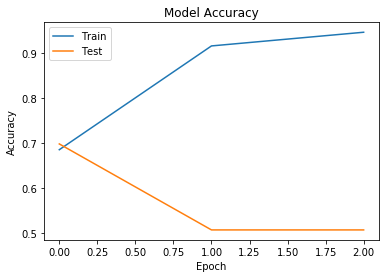

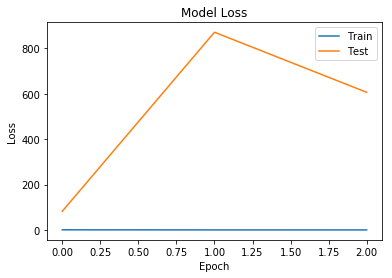

In [203]:
#plotting
def plot_hist(mod_hist):
    plt.plot(mod_hist.history['accuracy'])
    plt.plot(mod_hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'])
    plt.show()
    plt.plot(mod_hist.history['loss'])
    plt.plot(mod_hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'])
    plt.show()
    
plot_hist(ret)

In [204]:
#confusion matrix details
Y_pred = model.predict(test_features)
y_pred = np.argmax(Y_pred, axis=1)
lb = [0 if val[0] == 1 else 1 for val in test_labels]
cm = confusion_matrix(lb, y_pred)

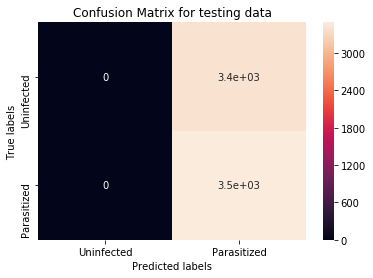

In [205]:
#ploting 
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for testing data'); 
ax.xaxis.set_ticklabels(['Uninfected', 'Parasitized']); ax.yaxis.set_ticklabels(['Uninfected', 'Parasitized'])
plt.show()

In [206]:
#confusion matrix
Y_pred = model.predict(train_features)
y_pred = np.argmax(Y_pred, axis=1)
lb = [0 if val[0] == 1 else 1 for val in train_labels]
cm = confusion_matrix(lb, y_pred)

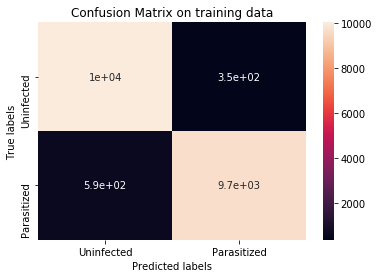

In [207]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix on training data'); 
ax.xaxis.set_ticklabels(['Uninfected', 'Parasitized']); ax.yaxis.set_ticklabels(['Uninfected', 'Parasitized'])
plt.show()

<div markdown=1 class="Rmk">The model predicts very well the training but completely fails on the testing which concludes that the dataset is too small or not complex enough for it to not be overfitted by the cnn.

In [208]:
#training our model on the augmented data
model.set_weights(Wsave)
ret_augmented = train_model_augmented_data(model, train_generator, validation_generator, 32, 10000, 3000, 10)

Epoch 1/10
312/312 [==============================] - 19s 61ms/step - loss: 0.6008 - accuracy: 0.6674 - val_loss: 0.9940 - val_accuracy: 0.5165
Epoch 2/10
312/312 [==============================] - 19s 60ms/step - loss: 0.2613 - accuracy: 0.9029 - val_loss: 0.1993 - val_accuracy: 0.9365
Epoch 3/10
312/312 [==============================] - 18s 59ms/step - loss: 0.1681 - accuracy: 0.9466 - val_loss: 0.2260 - val_accuracy: 0.9318
Epoch 4/10
312/312 [==============================] - 18s 58ms/step - loss: 0.1451 - accuracy: 0.9536 - val_loss: 0.1616 - val_accuracy: 0.9590
Epoch 5/10
312/312 [==============================] - 18s 57ms/step - loss: 0.1434 - accuracy: 0.9532 - val_loss: 0.1826 - val_accuracy: 0.9483
Epoch 6/10
312/312 [==============================] - 18s 57ms/step - loss: 0.1424 - accuracy: 0.9549 - val_loss: 0.2259 - val_accuracy: 0.9412


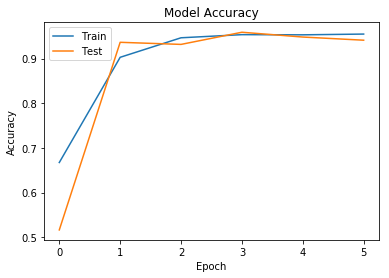

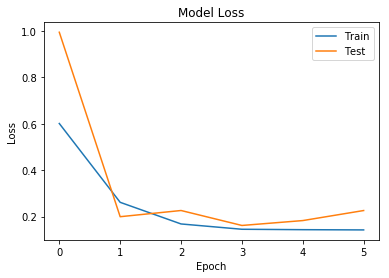

In [209]:
plot_hist(ret_augmented)

In [210]:
#confusion matrix for augmented data function
def confusion_matrix_plot(model, validation_generator, max_count):
    preds = []
    lbls = []
    count = 0
    for X,Y in validation_generator:
        predL = np.argmax(model.predict(X), axis = 1)
        for i in range(len(X)):
            pred = int(predL[i])
            lbl = int(Y[i][1])
            preds.append(pred)
            lbls.append(lbl)
            count += 1
            if count >= max_count:
                break
        if count >=  max_count:
            break
    cm = confusion_matrix(lbls, preds)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Uninfected', 'Parasitized'])
    ax.yaxis.set_ticklabels(['Uninfected', 'Parasitized'])
    plt.show()

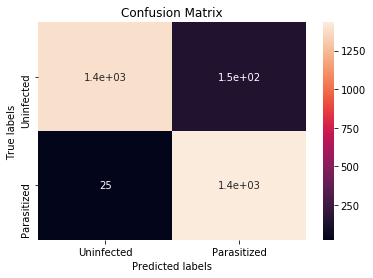

In [211]:
confusion_matrix_plot(model, validation_generator, 3000)

<div markdown=1 class="Rmk">
The model obtained an accuracy of 0.9533 on the testing data. If has a very good accuracy and loss function, very close to the training set. By the confusion matrix we observe that the cnn predicts very well

## Transfer learning

The fundamental idea behind transfer learning is that when huge CNNs are trained over humeonguous datasets, such as ImageNet, then the CNN learn not only how the detect the given classes it is trained on. The CNN also learns some "skills" that can be applied elsewhere, for example how to recognize a certain shape, so for example a model that learned how to differentiate a brick from a football might be able, with some adjustement, to learn how to differentiate a watermelon from a box.

***"Transfer learning and domain adaptation refer to the situation where what has been learned in one setting is exploited to improve generalization in another setting"***

— Page 526, Deep Learning, 2016.

In [216]:
# LOADING OF THE RESNET50 CNN and vgg16
base_model = ResNet50(weights='imagenet', include_top = False, input_shape=(64,64,3))
base_model2 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

/Users/megidervishi/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


### Transfered CNN as feature extractor:

As a first try we used the transfered CNN as a feature extractor. By this we mean that we remove the last dense softmax layer, and we just use the output from the previous one. Since the CNN uses this data to determine the class it means that this data represents some of the features of the image. The idea is then to use a linear classifier on this data to be able to determine the categories from it.

In [217]:
#ResNet50
feature_extractor = base_model
feature_extractor.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [218]:
#getting the features for different images before the last layer of cnn
features = []
labels = []
count = 0
max_count = 10000
for X,Y in train_generator: #X,Y list of 32 images/labels because of train_generator
    predL = feature_extractor.predict(X)
    for i in range(len(predL)):
        features.append(predL[i].flatten())
        labels.append(Y[i][1])
        count += 1
        if count >= max_count:
            break
    if count >=  max_count:
        break

features = np.array(features)
labels = np.array(labels)

In [219]:
print(features.shape)
print(labels.shape)

(10000, 8192)
(10000,)


In [220]:
#apply linear classifier
clf = LinearSVC(random_state=0, tol=1e-5, max_iter = 10000)
clf.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [221]:
#Testing the accuracy of the linear classifier
count = 0
max_count = 3000
correct = 0
for X, Y in validation_generator:
    im_feat = feature_extractor.predict(X)
    for i in range(len(im_feat)):
        if clf.predict([im_feat[i].flatten()])[0] == Y[i][1]:
            correct += 1
        count += 1
        if count >= max_count:
            break
    if count >= max_count:
        break

accuracy = correct/max_count
print("Using ResNet50 on our augmented dataset we obtain an accuracy of ")
print(accuracy)

Using ResNet50 on our augmented dataset we obtain an accuracy of 
0.5956666666666667


Repeating the same process with another network we get:

In [222]:
feature_extractor2 = base_model2
#feauture extraction
features2 = []
labels2 = []
count = 0
max_count = 10000
for X,Y in train_generator:
    predL = feature_extractor2.predict(X)
    for i in range(len(predL)):
        features2.append(predL[i].flatten())
        labels2.append(Y[i][1])
        count += 1
        if count >= max_count:
            break
    if count >=  max_count:
        break

features2 = np.array(features2)
labels2 = np.array(labels2)
#apply linear svc
clf2 = LinearSVC(random_state=0, tol=1e-5, max_iter = 10000)
clf2.fit(features2, labels2)
#accuracy
count = 0
max_count = 3000
correct = 0
for X, Y in validation_generator:
    im_feat = feature_extractor2.predict(X)
    for i in range(len(im_feat)):
        if clf2.predict([im_feat[i].flatten()])[0] == Y[i][1]:
            correct += 1
        count += 1
        if count >= max_count:
            break
    if count >= max_count:
        break

accuracy = correct/max_count
print("Using VGG16 on our augmented dataset we obtain an accuracy of ")
print(accuracy)

Using VGG16 on our augmented dataset we obtain an accuracy of 
0.9136666666666666


### Testing through PCA and t-SNE

In [226]:
#Changing the dataset into a dataframe
col_tit = ['Output'+str(i) for i in range(features2.shape[1])]

df = pd.DataFrame(features2, columns=col_tit)
df['y'] = labels2
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

N = 5000 #number of points
df_subset = df.loc[rndperm[:N],:].copy() #choosing a subset of the dataset
data_subset = df_subset[col_tit].values

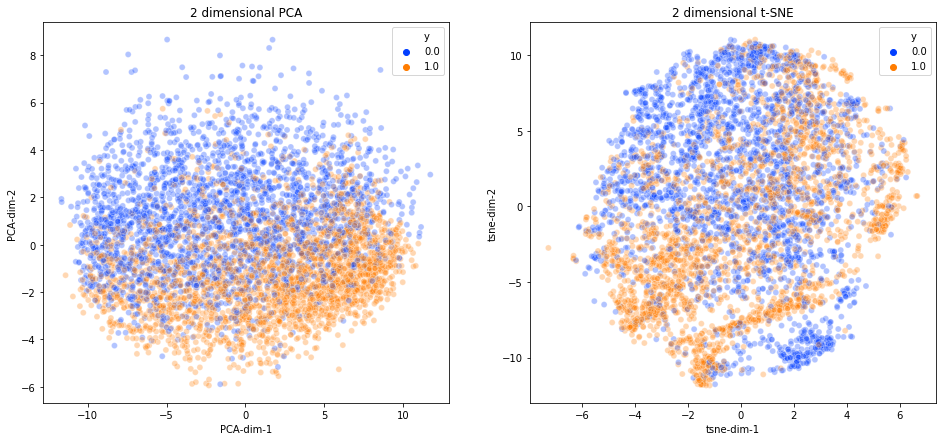

In [224]:
#PCA using dimension reduction of 800 components
pca2 = PCA(n_components=800)
pca_result = pca2.fit_transform(data_subset)
df_subset['PCA-dim-1'] = pca_result[:,0]
df_subset['PCA-dim-2'] = pca_result[:,1]

#t-SNE dimensionality reduction using pca results for more efficient results
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
df_subset['tsne-dim-1'] = tsne_results[:,0]
df_subset['tsne-dim-2'] = tsne_results[:,1]

#plot of the two methods
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title("2 dimensional PCA")
sns.scatterplot(x="PCA-dim-1", y="PCA-dim-2",hue="y",palette="bright",
                data=df_subset, legend="full",alpha=0.3, ax = ax1)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title("2 dimensional t-SNE")
sns.scatterplot(x="tsne-dim-1", y="tsne-dim-2",hue="y", palette="bright",
                data=df_subset, legend="full", alpha=0.3, ax=ax2)

plt.show()

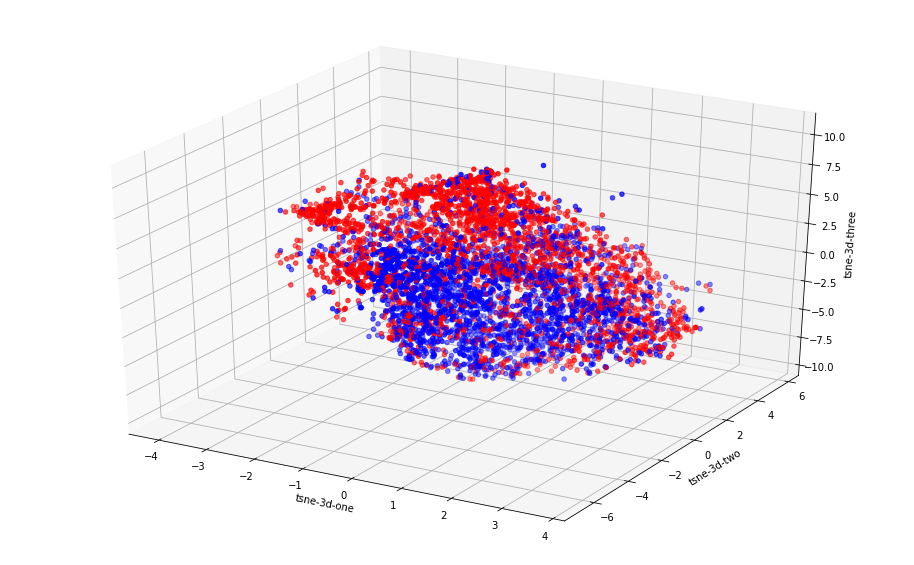

In [225]:
newpca = PCA(n_components=50)
pca_result_2 = newpca.fit_transform(data_subset)
_3D_tsne = TSNE(n_components=3, verbose=0, perplexity=50, n_iter=300)
tsne_results = _3D_tsne.fit_transform(pca_result_2)
df_subset['tsne-3d-one'] = tsne_results[:,0]
df_subset['tsne-3d-two'] = tsne_results[:,1]
df_subset['tsne-3d-three'] = tsne_results[:,2]


ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_subset['tsne-3d-one'], 
    ys=df_subset['tsne-3d-two'], 
    zs=df_subset['tsne-3d-three'], 
    c=df_subset["y"], 
    cmap='bwr'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()

## Re-training of the CNN:

The second option that we tried is to adapt the CNN to our problem, and simply train / re-train a few layers of the network so as to adapt it to our problem

In [227]:
# SIMPLE ADAPTION OF EXISTING CNN TO CHECK FOR 
def simple_transfer_of_model(base_model, num_classes):
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    # New output layer to match number of output to number of classes
    predictions = Dense(num_classes, activation='softmax')(x) 
    transfered_model = Model(inputs=base_model.input, outputs=predictions)
    return transfered_model

In [228]:
transfered_model = simple_transfer_of_model(base_model2, num_classes=2)
transfered_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

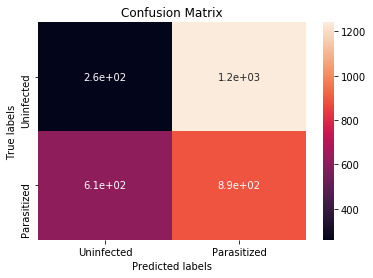

In [229]:
confusion_matrix_plot(transfered_model, validation_generator, 3000)

In [230]:
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
transfered_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [231]:
transfered_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [232]:
test_ret = train_model_augmented_data(transfered_model, train_generator, validation_generator, 32, 10000, 3000, 5)

Epoch 1/5
312/312 [==============================] - 220s 704ms/step - loss: 0.3219 - accuracy: 0.8662 - val_loss: 0.4467 - val_accuracy: 0.7873
Epoch 2/5
312/312 [==============================] - 224s 717ms/step - loss: 0.2468 - accuracy: 0.9028 - val_loss: 0.3239 - val_accuracy: 0.8532
Epoch 3/5
312/312 [==============================] - 283s 907ms/step - loss: 0.2199 - accuracy: 0.9154 - val_loss: 0.2985 - val_accuracy: 0.8740
Epoch 4/5
312/312 [==============================] - 221s 708ms/step - loss: 0.2130 - accuracy: 0.9160 - val_loss: 0.2475 - val_accuracy: 0.9086
Epoch 5/5
312/312 [==============================] - 226s 724ms/step - loss: 0.2089 - accuracy: 0.9168 - val_loss: 0.3400 - val_accuracy: 0.8619


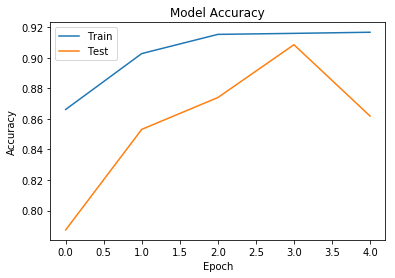

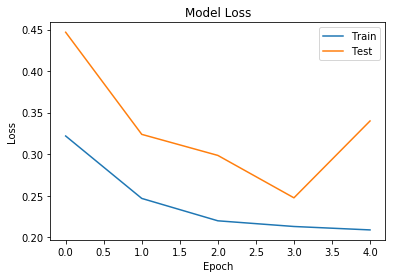

In [233]:
plot_hist(test_ret)

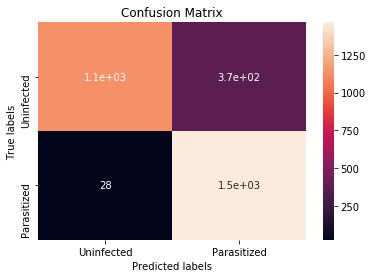

In [234]:
confusion_matrix_plot(transfered_model, validation_generator, 3000)

In [235]:
def transfer_and_retrain_final_layers(base_model, cutoff, num_classes):
    for layer in base_model.layers[:len(base_model.layers)-cutoff]: #Freeze all layers before cutoff
        layer.trainable = False
    for layer in base_model.layers[len(base_model.layers)-cutoff:]: #Allow all layers after cutoff to be re-trained
        layer.trainable = True
    x = base_model.output
    x = Flatten()(x)
    # New output layer to match number of output to number of classes
    predictions = Dense(num_classes, activation='softmax')(x) 
    transfered_model = Model(inputs=base_model.input, outputs=predictions)
    return transfered_model

In [236]:
def transfer_tune_and_retrain(base_model, dropout_val, dense_vals, cutoff, num_classes):
    for layer in base_model.layers[:len(base_model.layers)-cutoff]: #Freeze all layers before cutoff
        layer.trainable = False
    for layer in base_model.layers[len(base_model.layers)-cutoff:]: #Allow all layers after cutoff to be re-trained
        layer.trainable = True
    x = base_model.output
    x = Flatten()(x)
    for dense_val in dense_vals: #Add as many dense+dropout layers as wanted to tune the output of the model.
        x = Dense(dense_val, activation = 'relu')(x)
        x = Dropout(dropout_val)(x)
    # New output layer to match number of output to number of classes
    predictions = Dense(num_classes, activation='softmax')(x) 
    transfered_model = Model(inputs=base_model.input, outputs=predictions)
    return transfered_model

In [237]:
transfered_retrain_model = transfer_and_retrain_final_layers(base_model2, 2, num_classes=2)
transfered_retrain_model.summary()
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
transfered_retrain_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [238]:
test_retrain_ret = train_model_augmented_data(transfered_retrain_model, train_generator, 
                                              validation_generator, 32, 10000, 3000, 5)

Epoch 1/5
312/312 [==============================] - 256s 820ms/step - loss: 0.2892 - accuracy: 0.8918 - val_loss: 0.3835 - val_accuracy: 0.8572
Epoch 2/5
312/312 [==============================] - 254s 815ms/step - loss: 0.2114 - accuracy: 0.9180 - val_loss: 0.2106 - val_accuracy: 0.9382
Epoch 3/5
312/312 [==============================] - 253s 812ms/step - loss: 0.1887 - accuracy: 0.9295 - val_loss: 0.2276 - val_accuracy: 0.9281
Epoch 4/5
312/312 [==============================] - 249s 797ms/step - loss: 0.1814 - accuracy: 0.9303 - val_loss: 0.2456 - val_accuracy: 0.9147


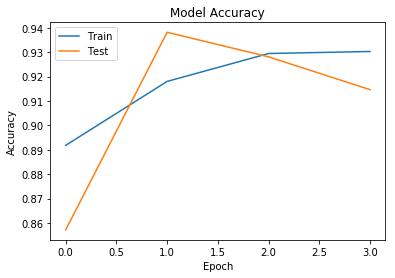

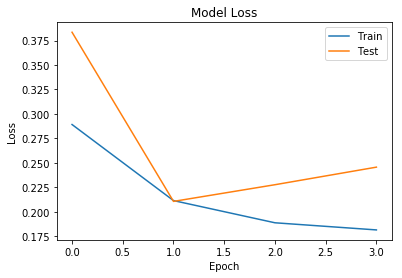

In [239]:
plot_hist(test_retrain_ret)

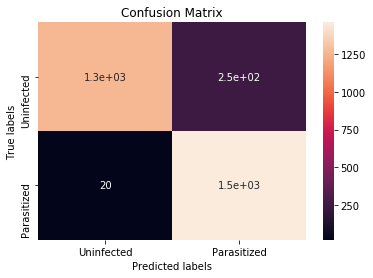

In [240]:
confusion_matrix_plot(transfered_retrain_model, validation_generator, 3000)

## Subgroup detection

Now we want to try and see if our CNN could detect feature allowing us to detect sub-group within the already existing ones. To do so we remove the last dense layers of the previous network and then we train a linear classifier on the data for one group, and then the next.

In [241]:
sub_model = model
sub_model = Model(inputs=model.input, outputs=model.get_layer('flatten_6').output)

In [ ]:
sub_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9_input (InputLayer)  [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 21, 32)        2080      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)          8256      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 2, 2, 64)          0   

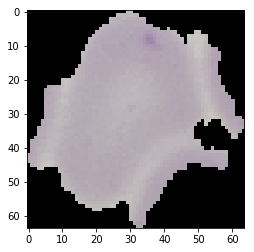

In [272]:
feat_space_uninfected = []
count = 0
max_count = 1500
ex = False
for X,Y in validation_generator:
    preds = sub_model.predict(X)
    for i in range(len(preds)):
        if Y[i][1] == 0: #if the label is infected skip
            continue
        if not ex: #just a plot
            plt.imshow(X[i])
            plt.show()
            ex = True
        feat_space_uninfected.append(preds[i]) #append to the features
        count += 1
        if count >= max_count:
            break
    if count >= max_count:
        break

feat_space_uninfected = np.array(feat_space_uninfected)

col_tit = ['Output'+str(i) for i in range(feat_space_uninfected.shape[1])]

df = pd.DataFrame(feat_space_uninfected, columns=col_tit)
df['y'] = [1]*len(feat_space_uninfected)
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

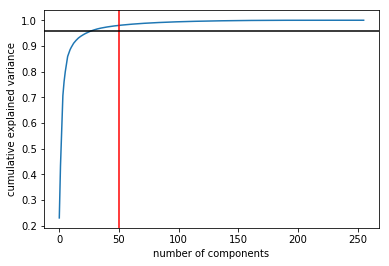

In [288]:
N = 5000 #number of points
df_subset = df.loc[rndperm[:N],:].copy() #choosing a subset of the dataset
data_subset = df_subset[col_tit].values

#how many components should pca be 
pca = PCA().fit(data_subset)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(50, c='red')
plt.axhline(0.96, c='black')

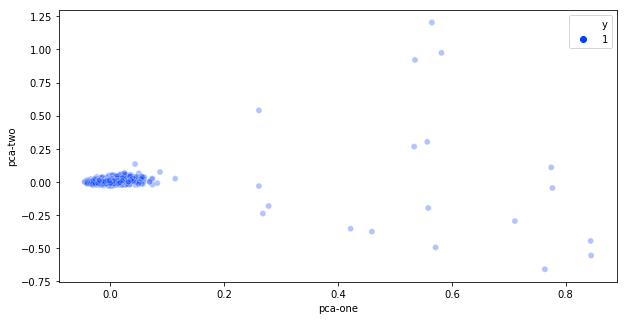

In [274]:
pca2 = PCA(n_components=50)
pca_result = pca2.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1]

plt.figure(figsize=(10,5))
sns.scatterplot(x="pca-one", y="pca-two", hue="y",palette=sns.color_palette("bright", 1),data=df_subset,
                legend="full",alpha=0.3)

t-SNE done! Time elapsed: 64.09486484527588 seconds


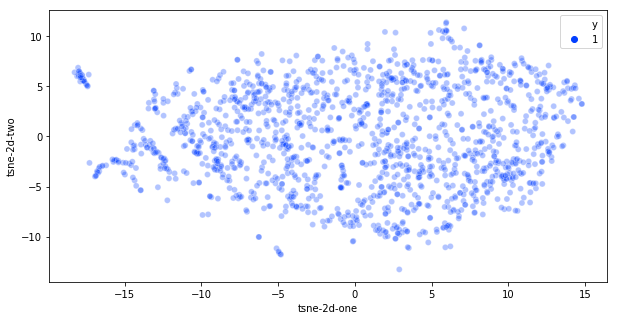

In [275]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(10,5))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",hue = "y",palette=sns.color_palette("bright", 1),
                data=df_subset,legend="full",alpha=0.3)

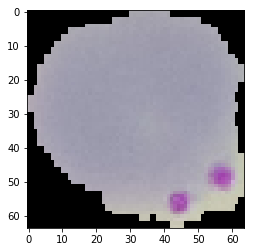

In [279]:
feat_space_infected = []
count = 0
ex = False
max_count = 1500
for X,Y in validation_generator: #INFECTED CELLS NOW 
    preds = sub_model.predict(X)
    for i in range(len(preds)):
        if Y[i][1] == 1:
            continue
        if not ex:
            plt.imshow(X[i])
            plt.show()
            ex = True
        feat_space_infected.append(preds[i])
        count += 1
        if count >= max_count:
            break
    if count >= max_count:
        break

feat_space_infected = np.array(feat_space_infected)

col_tit = ['Output'+str(i) for i in range(feat_space_infected.shape[1])]

df = pd.DataFrame(feat_space_infected, columns=col_tit)
df['y'] = [1]*len(feat_space_infected)
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

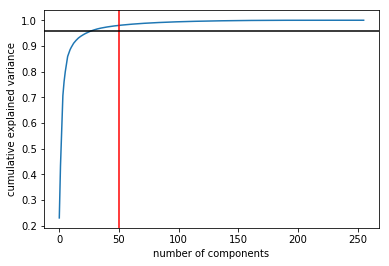

In [289]:
N = 5000 #number of points
df_subset = df.loc[rndperm[:N],:].copy() #choosing a subset of the dataset
data_subset = df_subset[col_tit].values

#how many components should pca be 
pca = PCA().fit(data_subset)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(50, c='red')
plt.axhline(0.96, c='black')

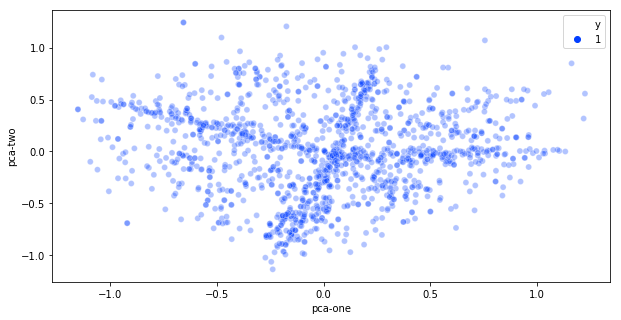

In [281]:
pca2 = PCA(n_components=50)
pca_result = pca2.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1]

plt.figure(figsize=(10,5))
sns.scatterplot(x="pca-one", y="pca-two", hue="y",palette=sns.color_palette("bright", 1),data=df_subset,
                legend="full",alpha=0.3)

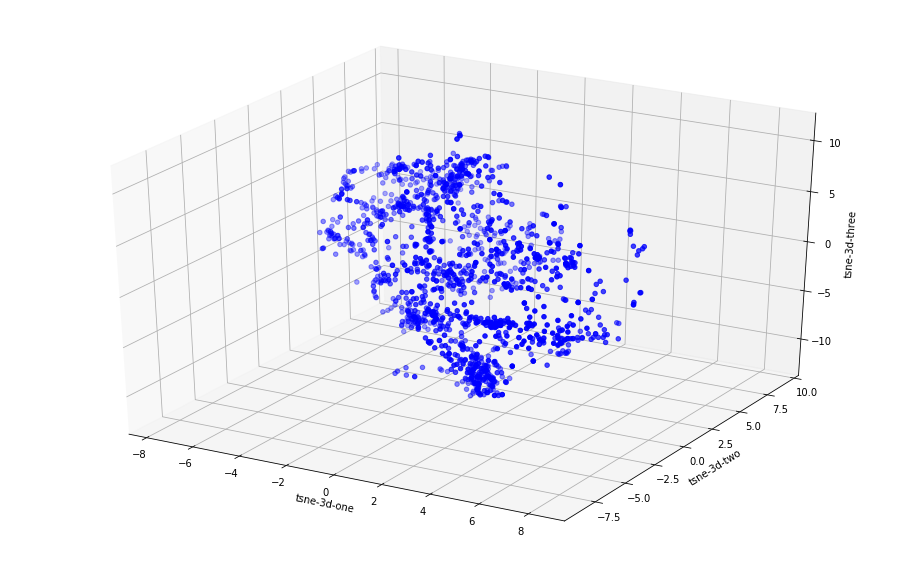

In [282]:
newpca = PCA(n_components=50)
pca_result_2 = newpca.fit_transform(data_subset)
_3D_tsne = TSNE(n_components=3, verbose=0, perplexity=50, n_iter=300)
tsne_results = _3D_tsne.fit_transform(pca_result_2)
df_subset['tsne-3d-one'] = tsne_results[:,0]
df_subset['tsne-3d-two'] = tsne_results[:,1]
df_subset['tsne-3d-three'] = tsne_results[:,2]


ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_subset['tsne-3d-one'], 
    ys=df_subset['tsne-3d-two'], 
    zs=df_subset['tsne-3d-three'], 
    c=df_subset["y"], 
    cmap='bwr'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()

t-SNE done! Time elapsed: 50.64188504219055 seconds


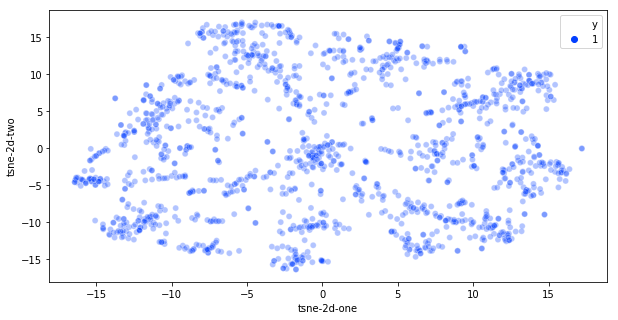

In [283]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(10,5))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",hue = "y",palette=sns.color_palette("bright", 1),
                data=df_subset,legend="full",alpha=0.3)

In [284]:
nb_clusters = 3
kmeans = KMeans(init='k-means++', n_clusters=nb_clusters, n_init=10)
reduced_data = PCA(n_components=2).fit_transform(data_subset)
y_pred_kmeans = kmeans.fit_predict(reduced_data)

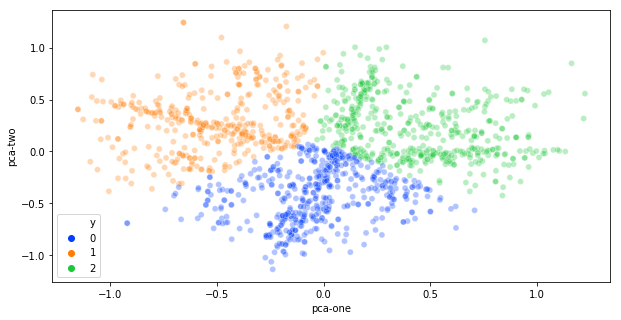

In [285]:
df_subset['y'] = y_pred_kmeans
plt.figure(figsize=(10,5))
plt.figure(figsize=(10,5))
sns.scatterplot(x="pca-one", y="pca-two", hue="y",palette=sns.color_palette("bright", nb_clusters),data=df_subset,
                legend="full",alpha=0.3)

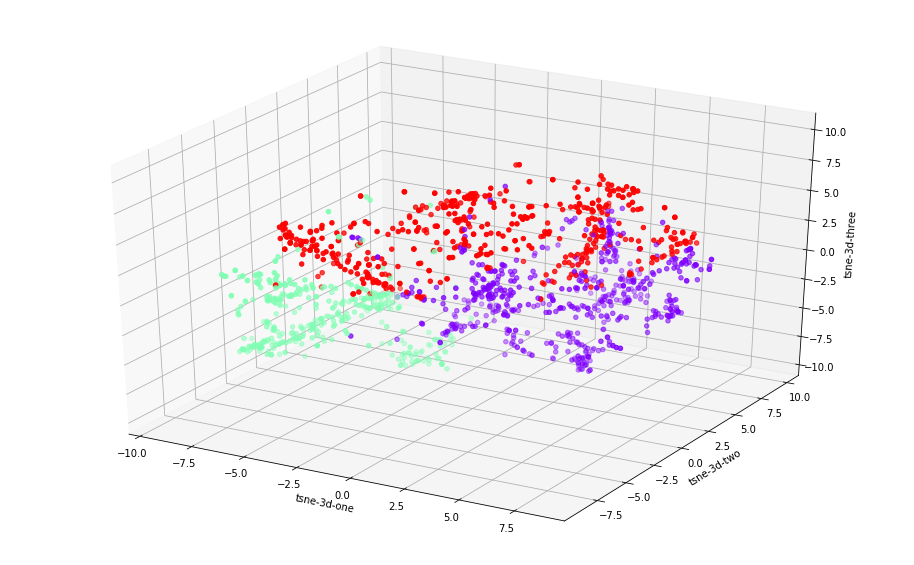

In [287]:
newpca = PCA(n_components=50)
pca_result_2 = newpca.fit_transform(data_subset)
_3D_tsne = TSNE(n_components=3, verbose=0, perplexity=50, n_iter=300)
tsne_results = _3D_tsne.fit_transform(pca_result_2)
df_subset['tsne-3d-one'] = tsne_results[:,0]
df_subset['tsne-3d-two'] = tsne_results[:,1]
df_subset['tsne-3d-three'] = tsne_results[:,2]


ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_subset['tsne-3d-one'], 
    ys=df_subset['tsne-3d-two'], 
    zs=df_subset['tsne-3d-three'], 
    c=df_subset["y"], 
    cmap='rainbow'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')
plt.show()

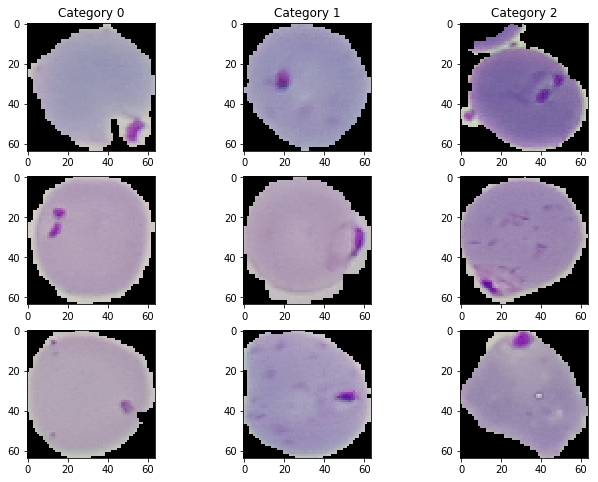

In [267]:
#printing of the pictures.
count = 0
type_count = 0
max_count = 1500
l_count = 0
f, axes = plt.subplots(3, nb_clusters, figsize=(11,8))
for X,Y in validation_generator:
    preds = sub_model.predict(X)
    reduced_data = PCA(n_components=2).fit_transform(preds)
    y_pred_kmeans = kmeans.fit_predict(reduced_data)
    for i in range(len(preds)):
        if Y[i][1] == 1:
            continue
        if y_pred_kmeans[i] == type_count:
            if l_count == 0:
                axes[l_count, type_count].set_title('Category {}'.format(type_count))
            axes[l_count, type_count].imshow(X[i])
            type_count += 1
            if type_count == nb_clusters:
                l_count += 1
                type_count = 0
        count += 1
        if count >= max_count or l_count == 3:
            break
    if count >= max_count or l_count == 3:
        break

plt.show()

## Bibliography

https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/

https://arxiv.org/abs/1411.1792 